## TEXT CLASSIFICATION USING NAIVE BAYES AND SENTIMENT ANALYSIS ON BLOG POSTS

### Exploratory Data Analysis

In [85]:
# Importing neccessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from collections import Counter
warnings.filterwarnings('ignore')
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

In [39]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [40]:
# Read the data
df = pd.read_csv('blogs_categories.csv')
df.head()

,Unnamed: 0,Data,Labels
0,0,Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:49...,alt.atheism
1,1,Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:51...,alt.atheism
2,2,Newsgroups: alt.atheism\nPath: cantaloupe.srv....,alt.atheism
3,3,Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:51...,alt.atheism
4,4,Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:51...,alt.atheism


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19997 entries, 0 to 19996
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  19997 non-null  int64 
 1   Data        19997 non-null  object
 2   Labels      19997 non-null  object
dtypes: int64(1), object(2)
memory usage: 468.8+ KB


There are no null values in the data

In [42]:
df['Labels'].value_counts()

,count
Labels,
alt.atheism,1000
comp.graphics,1000
talk.politics.misc,1000
talk.politics.mideast,1000
talk.politics.guns,1000
sci.space,1000
sci.med,1000
sci.electronics,1000
sci.crypt,1000


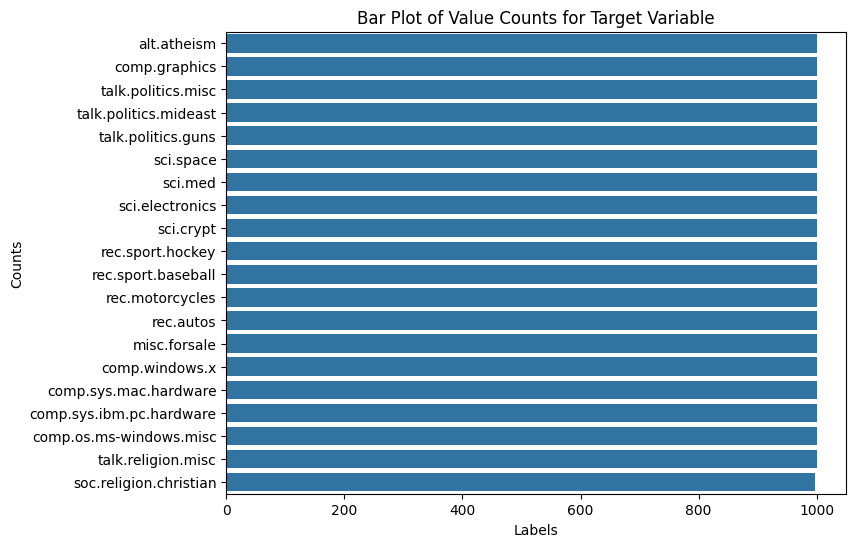

In [43]:
# Distribuation of labeles
plt.figure(figsize=(8, 6))
sns.barplot(y=df['Labels'].value_counts().index, x=df['Labels'].value_counts().values)
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Bar Plot of Value Counts for Target Variable')
plt.show()

From the above graph it is clear that all the classes are balanced.

In [44]:
# Length of blog posts
df['text_length'] = df['Data'].apply(len)
df['text_length'].describe()

,text_length
count,19997.000000
mean,2306.974196
std,3912.979447
min,345.000000
25%,1139.000000
50%,1600.000000
75%,2321.000000
max,161040.000000


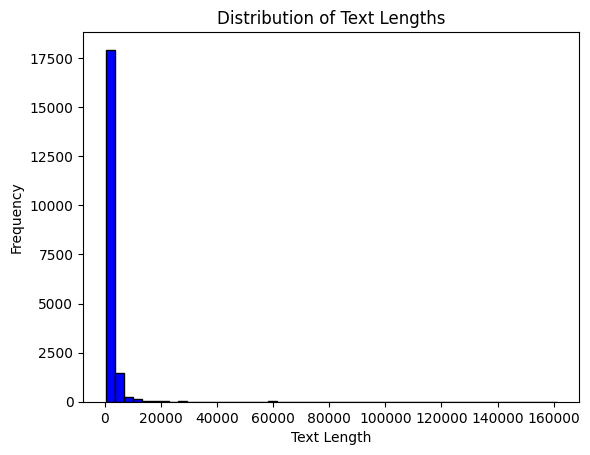

In [45]:
#Histogram of text lengths
plt.hist(df['text_length'], bins=50, color='blue', edgecolor='black')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.show()

In [46]:
# Average text length of each category
avg_text_length_by_label = df.groupby('Labels')['text_length'].mean()
avg_text_length_by_label

,text_length
Labels,
alt.atheism,2558.273000
comp.graphics,2177.669000
comp.os.ms-windows.misc,2894.756000
comp.sys.ibm.pc.hardware,1667.162000
comp.sys.mac.hardware,1576.877000
comp.windows.x,2414.269000
misc.forsale,1408.008000
rec.autos,1776.498000
rec.motorcycles,1673.960000


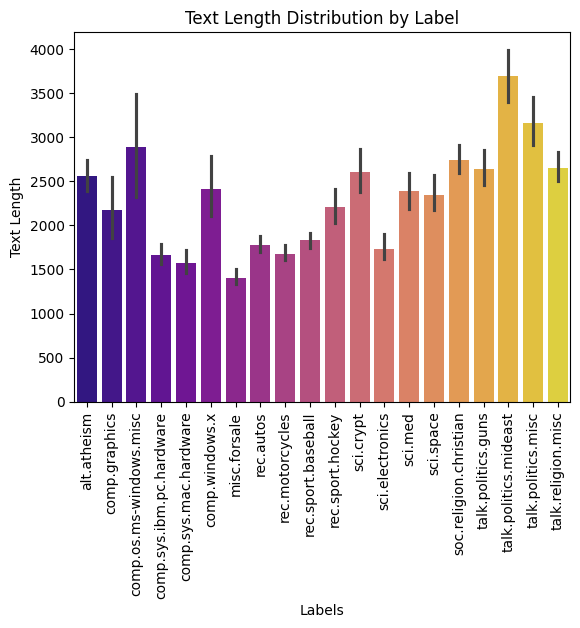

In [47]:
# Plot average text length of each category
sns.barplot(x='Labels', y='text_length', data=df, palette='plasma')
plt.xticks(rotation=90)
plt.xlabel('Labels')
plt.ylabel('Text Length')
plt.title('Text Length Distribution by Label')
plt.show()

### Preprocessing of Data

Removing punctuation, converting text to lowercase, tokenizing, and removing stopwords.

In [48]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Convert to lowercase
    text = text.lower()
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    # Lemmatize the tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [49]:
# Apply preprocessing
data = df.copy()
# Apply preprocessing
data['Data'] = data['Data'].apply(preprocess_text)
data.head()

,Unnamed: 0,Data,Labels,text_length
0,0,xref cantaloupesrvcscmuedu altatheism altathei...,alt.atheism,12424
1,1,xref cantaloupesrvcscmuedu altatheism altathei...,alt.atheism,32530
2,2,newsgroups altatheism path cantaloupesrvcscmue...,alt.atheism,4550
3,3,xref cantaloupesrvcscmuedu altatheism altpolit...,alt.atheism,2067
4,4,xref cantaloupesrvcscmuedu altatheism socmotss...,alt.atheism,1347


#### Word Cloud Visualization

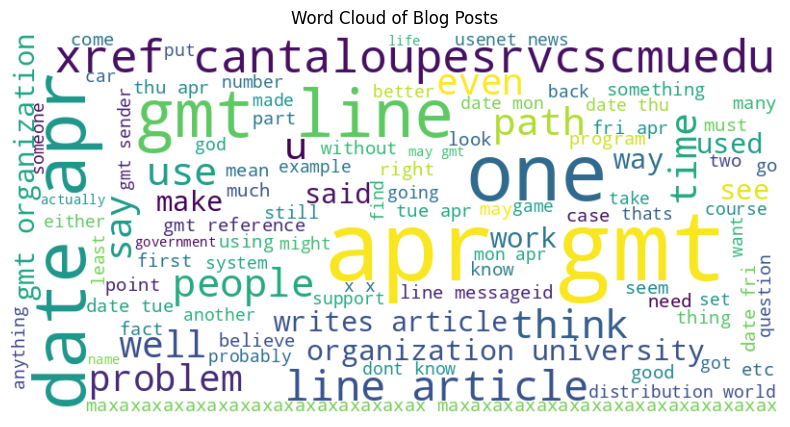

In [50]:
from wordcloud import WordCloud

# Visulization
wordcloud = WordCloud(width=800, height=400, max_font_size=100, max_words=100, background_color='white').generate(data['Data'].str.cat(sep=' '))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Blog Posts')
plt.show()

#### Performing Feature Extraction Using TF-IDF

In [51]:
# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the cleaned text data
X = vectorizer.fit_transform(data['Data'])

# Extract labels
y = data['Labels']

### Naive Bayes Model for Text Classification

#### Split the Data into Training and Test Sets

In [52]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Training the Naive Bayes Classifier

In [53]:
# Initialize the Naive Bayes classifier
nb_classifier = MultinomialNB()

# Train the model
nb_classifier.fit(X_train, y_train)

# Make predictions
y_pred = nb_classifier.predict(X_test)

In [54]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

# Detailed classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.90275
Precision: 0.9015964133898945
Recall: 0.90275
F1-Score: 0.9013212122547044
                          precision    recall  f1-score   support

             alt.atheism       0.76      0.79      0.77       173
           comp.graphics       0.87      0.91      0.89       179
 comp.os.ms-windows.misc       0.95      0.89      0.92       226
comp.sys.ibm.pc.hardware       0.87      0.84      0.85       204
   comp.sys.mac.hardware       0.89      0.95      0.92       205
          comp.windows.x       0.95      0.94      0.94       186
            misc.forsale       0.90      0.82      0.86       190
               rec.autos       0.92      0.94      0.93       203
         rec.motorcycles       1.00      0.97      0.98       218
      rec.sport.baseball       0.99      0.98      0.99       192
        rec.sport.hockey       0.98      0.99      0.98       203
               sci.crypt       0.90      0.99      0.94       200
         sci.electronics       0.95      0.90   

### Hyperparameters Tuning

In [55]:
param_grid = {
    'alpha': [0.1, 0.5, 1.0]
}

In [56]:
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.5, 1.0]}, scoring='accuracy')

In [57]:
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", grid_search.best_score_)

Best parameters found:  {'alpha': 0.1}
Best cross-validation accuracy:  0.9085454438887153


In [83]:
y_pred_tuned = grid_search.predict(X_test)
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_tuned)
precision = precision_score(y_test, y_pred_tuned, average='weighted')
recall = recall_score(y_test, y_pred_tuned, average='weighted')
f1 = f1_score(y_test, y_pred_tuned, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

# Detailed classification report
print(classification_report(y_test, y_pred_tuned))

Accuracy: 0.9075
Precision: 0.9064308037973811
Recall: 0.9075
F1-Score: 0.9063408610138124
                          precision    recall  f1-score   support

             alt.atheism       0.75      0.77      0.76       173
           comp.graphics       0.85      0.92      0.88       179
 comp.os.ms-windows.misc       0.96      0.88      0.92       226
comp.sys.ibm.pc.hardware       0.85      0.84      0.84       204
   comp.sys.mac.hardware       0.92      0.95      0.93       205
          comp.windows.x       0.95      0.94      0.94       186
            misc.forsale       0.91      0.82      0.86       190
               rec.autos       0.91      0.95      0.93       203
         rec.motorcycles       1.00      0.98      0.99       218
      rec.sport.baseball       0.99      0.98      0.99       192
        rec.sport.hockey       0.99      0.99      0.99       203
               sci.crypt       0.93      0.99      0.96       200
         sci.electronics       0.92      0.94     

### Sentiment Analysis

We'll use the TextBlob library to perform sentiment analysis:

In [59]:
# Function to get sentiment
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'

In [61]:
# Apply sentiment analysis on processed data
data['sentiment'] = data['Data'].apply(get_sentiment)

# Display the first few rows with sentiment
data.head()

,Unnamed: 0,Data,Labels,text_length,sentiment
0,0,xref cantaloupesrvcscmuedu altatheism altathei...,alt.atheism,12424,positive
1,1,xref cantaloupesrvcscmuedu altatheism altathei...,alt.atheism,32530,positive
2,2,newsgroups altatheism path cantaloupesrvcscmue...,alt.atheism,4550,positive
3,3,xref cantaloupesrvcscmuedu altatheism altpolit...,alt.atheism,2067,positive
4,4,xref cantaloupesrvcscmuedu altatheism socmotss...,alt.atheism,1347,negative


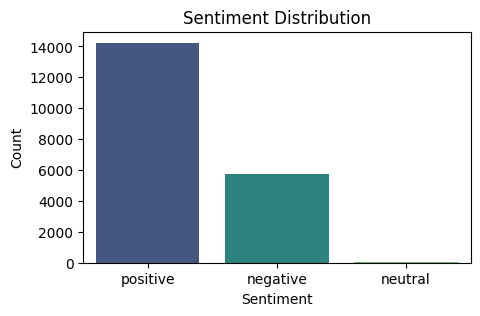

In [64]:
# Plot sentiment distribution
plt.figure(figsize=(5, 3))
sns.countplot(x='sentiment', data=data, palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

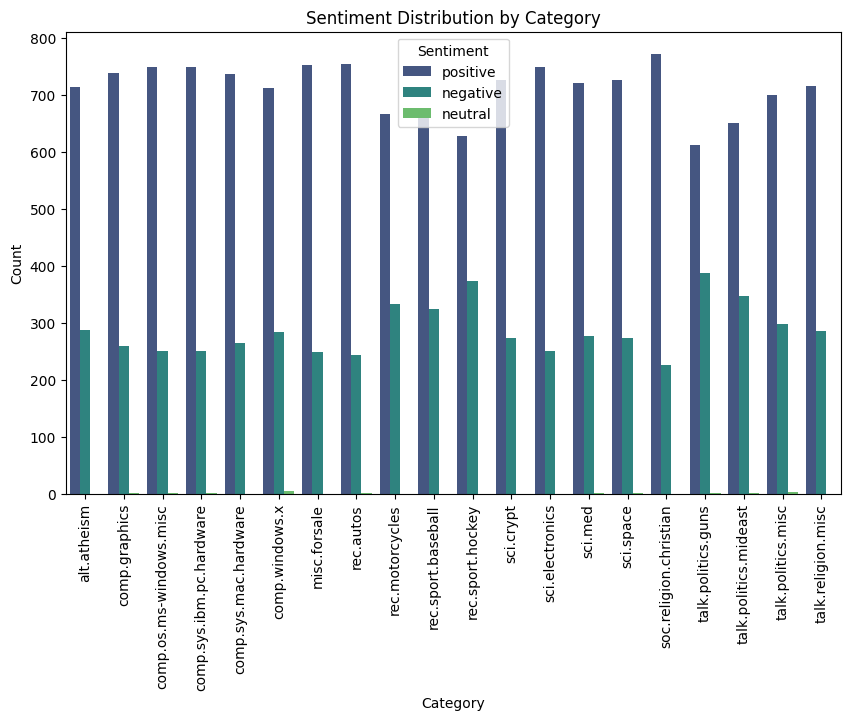

In [67]:
# Plot sentiment distribution by category
plt.figure(figsize=(10, 6))
sns.countplot(x='Labels', hue='sentiment', data=data, palette='viridis')
plt.title('Sentiment Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Sentiment')
plt.show()

#### Sentiment Scores

In [69]:
# Calculate sentiment scores
total_sentiment = data['sentiment'].value_counts(normalize=True) * 100
print("Overall Sentiment Distribution (Percentage):")
total_sentiment

Overall Sentiment Distribution (Percentage):


,proportion
sentiment,
positive,71.225684
negative,28.679302
neutral,0.095014


In [84]:
# Calculate sentiment scores by category
category_sentiment = data.groupby('Labels')['sentiment'].value_counts(normalize=True).unstack() * 100
print("\nSentiment Distribution by Category (Percentage):")
category_sentiment


Sentiment Distribution by Category (Percentage):


sentiment,negative,neutral,positive
Labels,,,
alt.atheism,28.700000,NaN,71.300000
comp.graphics,26.000000,0.1,73.900000
comp.os.ms-windows.misc,25.100000,0.1,74.800000
comp.sys.ibm.pc.hardware,25.000000,0.1,74.900000
comp.sys.mac.hardware,26.400000,NaN,73.600000
comp.windows.x,28.300000,0.5,71.200000
misc.forsale,24.800000,NaN,75.200000
rec.autos,24.400000,0.2,75.400000
rec.motorcycles,33.300000,NaN,66.700000


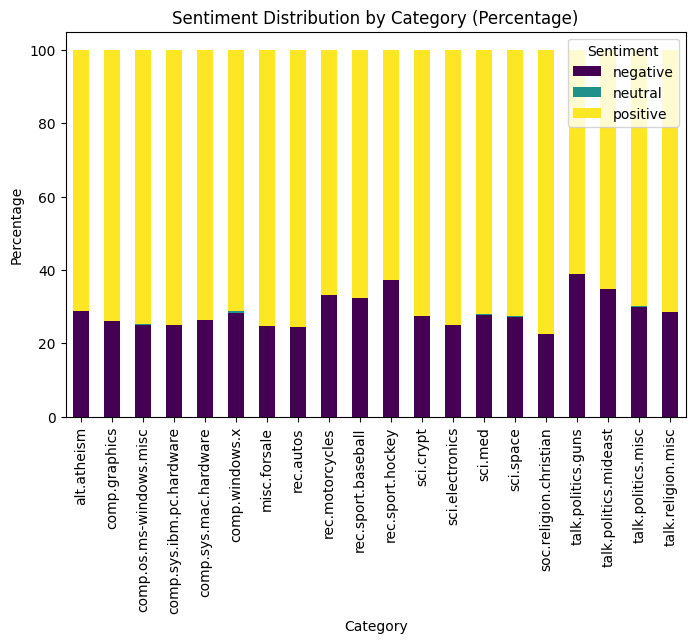

In [74]:
# Visualize the sentiment distribution by category
category_sentiment.plot(kind='bar', stacked=True, figsize=(8, 5), colormap='viridis')
plt.title('Sentiment Distribution by Category (Percentage)')
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.legend(title='Sentiment')
plt.xticks(rotation=90)
plt.show()

In [76]:
# Separate the data by sentiment
positive_data = data[data['sentiment'] == 'positive']['Data']
negative_data = data[data['sentiment'] == 'negative']['Data']
neutral_data = data[data['sentiment'] == 'neutral']['Data']

In [77]:
# Function to get the most common words
def get_most_common_words(text_data, num_words=10):
    all_words = ' '.join(text_data).split()
    counter = Counter(all_words)
    most_common_words = counter.most_common(num_words)
    return most_common_words

In [78]:
# Get the most common words for each sentiment
positive_common_words = get_most_common_words(positive_data)
negative_common_words = get_most_common_words(negative_data)
neutral_common_words = get_most_common_words(neutral_data)

In [79]:
# Convert the most common words to DataFrame for visualization
positive_df = pd.DataFrame(positive_common_words, columns=['word', 'count'])
negative_df = pd.DataFrame(negative_common_words, columns=['word', 'count'])
neutral_df = pd.DataFrame(neutral_common_words, columns=['word', 'count'])

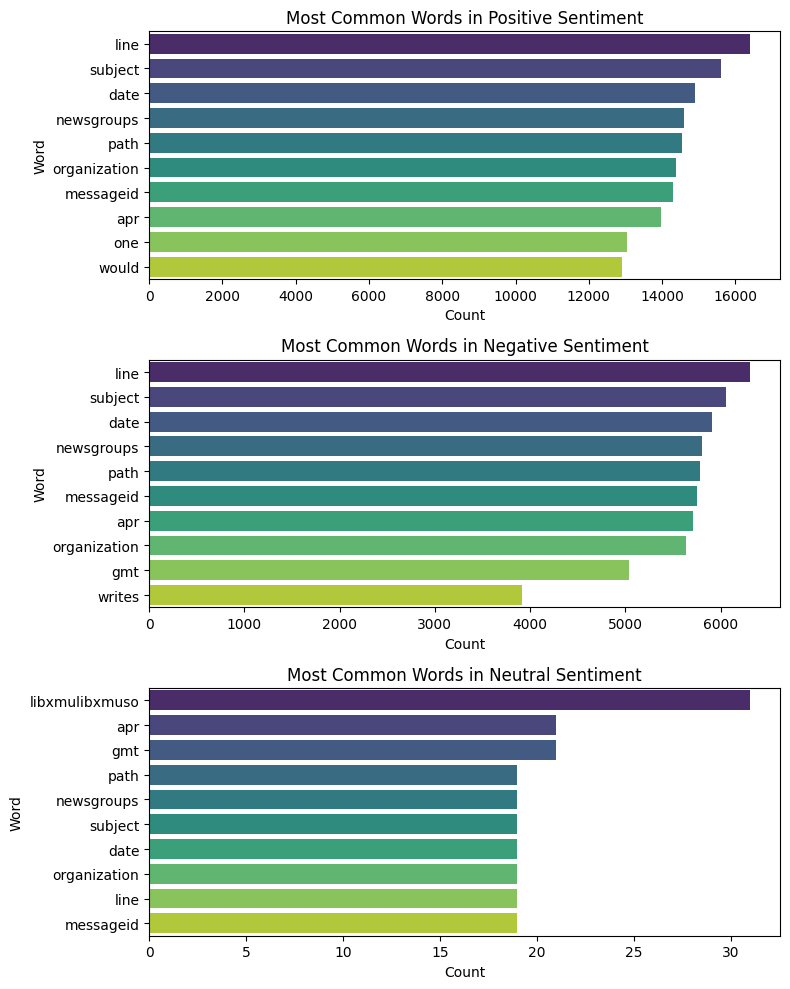

In [82]:
# Plot the most common words for each sentiment
fig, axes = plt.subplots(3, 1, figsize=(8, 10))

sns.barplot(x='count', y='word', data=positive_df, palette='viridis', ax=axes[0])
axes[0].set_title('Most Common Words in Positive Sentiment')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')

sns.barplot(x='count', y='word', data=negative_df, palette='viridis', ax=axes[1])
axes[1].set_title('Most Common Words in Negative Sentiment')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')

sns.barplot(x='count', y='word', data=neutral_df, palette='viridis', ax=axes[2])
axes[2].set_title('Most Common Words in Neutral Sentiment')
axes[2].set_xlabel('Count')
axes[2].set_ylabel('Word')

plt.tight_layout()
plt.show()

### Analysis Summary and Conclusions

#### Model Performance

The Naive Bayes model demonstrated strong performance in classifying the blog posts with an accuracy of around 90%. Hyperparameter tuning resulted in slight improvements across all metrics. Specifically, accuracy increased from 90.28% to 90.75%, and F1-Score improved from 90.13% to 90.63%. These improvements, though modest, highlight the effectiveness of hyperparameter optimization in refining model performance.

#### Sentiment Analysis

The sentiment analysis revealed the following proportions:
- **Positive**: 71.23%
- **Negative**: 28.68%
- **Neutral**: 0.10%

This indicates that the majority of blog posts express a positive sentiment, with a smaller portion reflecting negative sentiment. The near-zero proportion of neutral sentiment suggests that most blog posts are clearly positive or negative in tone.

**Sentiment Distribution by Category:**

The sentiment distribution varies significantly across different categories:

- **Alt.atheism**, **comp.graphics**, and **misc.forsale** have high proportions of positive sentiment, ranging from 71% to 75%.
- **Rec.sport.hockey**, **talk.politics.guns**, and **talk.politics.mideast** show lower positive sentiment and higher negative sentiment, indicating more critical or contentious discussions in these categories.
- Categories such as **soc.religion.christian** and **rec.motorcycles** display a balanced distribution with a notable positive sentiment.

#### Conclusions

1. **Model Performance**: The Naive Bayes classifier performs robustly in classifying blog posts into their respective categories. The hyperparameter tuning led to improved performance, demonstrating the importance of model optimization.

2. **Sentiment Distribution**: The overwhelming majority of blog posts are classified as positive, with a small proportion showing negative sentiment. The minimal presence of neutral sentiment suggests that the content is often clear-cut in its sentiment.

3. **Category Insights**: Different categories exhibit varied sentiment distributions, which can be crucial for understanding the nature of discussions in specific domains. For instance, technical and specialized categories may lean towards positive sentiment, while political and contentious topics may exhibit more balanced or negative sentiments.

Overall, this analysis provides valuable insights into the performance of text classification models and the sentiment expressed in blog posts, which can inform further improvements and applications in sentiment-driven tasks.
